<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/SafeGraph-visit-trend-by-category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import gzip as gz
import os
from pathlib import Path
import json
import matplotlib.pyplot as plt

from glob import glob
import time

import os
from shutil import copyfile, copytree

## Load the SafeGraph data from Google Drive
Load visit patterns from march-june 2019 for the desired place types, keep places that have data for entire march-june range
* places
* cbg_pop
* patterns_2019

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls drive/My\ Drive/SafeGraph

 census_vs_safegraph_IL.csv    places
 daily_visits_2019.csv	      'Places Schema.url'
 daily_visits_2020.csv	       places_v3_safegraph.csv
'Data Science Resources.url'   safegraph_panel
 historic		       social-distancing
'INRIX DATA.zip'	       vis_2020
 monthly		       weekly
 patterns_covid.csv.gz	      'Weekly Patterns.url'
 Patterns_NE-IL_2019.csv.gz    weekly_v2


In [4]:
# grab the SafeGraph core places
files = glob("drive/My Drive/SafeGraph/*.csv*")
print(files)

['drive/My Drive/SafeGraph/places_v3_safegraph.csv', 'drive/My Drive/SafeGraph/census_vs_safegraph_IL.csv', 'drive/My Drive/SafeGraph/Patterns_NE-IL_2019.csv.gz', 'drive/My Drive/SafeGraph/daily_visits_2019.csv', 'drive/My Drive/SafeGraph/daily_visits_2020.csv', 'drive/My Drive/SafeGraph/patterns_covid.csv.gz']


In [5]:
if not os.path.exists('sg_data'):
  os.mkdir('sg_data')

In [6]:
# copy these files from Google Drive to colab disk
for f in files:
  print(f)
  copyfile(f, 'sg_data/' + os.path.basename(f))

drive/My Drive/SafeGraph/places_v3_safegraph.csv
drive/My Drive/SafeGraph/census_vs_safegraph_IL.csv
drive/My Drive/SafeGraph/Patterns_NE-IL_2019.csv.gz
drive/My Drive/SafeGraph/daily_visits_2019.csv
drive/My Drive/SafeGraph/daily_visits_2020.csv
drive/My Drive/SafeGraph/patterns_covid.csv.gz


In [7]:
#!ls sg_data
local_files = glob("sg_data/*.csv*")
print(local_files)

['sg_data/Patterns_NE-IL_2019.csv.gz', 'sg_data/daily_visits_2020.csv', 'sg_data/census_vs_safegraph_IL.csv', 'sg_data/places_v3_safegraph.csv', 'sg_data/daily_visits_2019.csv', 'sg_data/patterns_covid.csv.gz']


In [8]:
place_df = pd.read_csv('sg_data/places_v3_safegraph.csv')
place_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74782 entries, 0 to 74781
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   numeric_id          74782 non-null  int64  
 1   place_id            74782 non-null  object 
 2   place_type          74782 non-null  object 
 3   latitude            74782 non-null  float64
 4   longitude           74782 non-null  float64
 5   name                74782 non-null  object 
 6   zipcode             74782 non-null  int64  
 7   visits_IL           64394 non-null  float64
 8   unique_visitors_IL  64394 non-null  float64
 9   cbg                 74782 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 5.7+ MB


In [9]:
place_types = [key for key in place_df['place_type'].value_counts().keys()]
place_types

['restaurant',
 'clinic',
 'recreation',
 'store',
 'worship',
 'pharmacy',
 'daycare',
 'supermarket',
 'convenience store',
 'long term care',
 'library',
 'bar',
 'museum',
 'hospital']

In [10]:
# Exrtact desired place types from v3 safegraph places file (7 county area)
places = place_df[['place_id', 'place_type']]

In [11]:
# Load cbg population vs safegraph devices
cbg_pop = pd.read_csv('sg_data/census_vs_safegraph_IL.csv') # https://anl.box.com/s/k2e7e833gfekqsihaachbj9pfsshhc2g
cbg_pop = cbg_pop[cbg_pop['state'] == 'IL'] # base table has a few non-IL cbgs
print("Number of IL cbgs (should be 9691): {}".format(len(cbg_pop)))

Number of IL cbgs (should be 9691): 9691


In [12]:
# load 2019 patterns
patterns_2019 = pd.read_csv('sg_data/Patterns_NE-IL_2019.csv.gz') # https://anl.box.com/s/zf3xt1cbd6vjs40e9njw91jm1jgkxj83

In [14]:
len(patterns_2019)

1233810

In [17]:
patterns_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1233810 entries, 0 to 1233809
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   safegraph_place_id         1233810 non-null  object 
 1   location_name              1233810 non-null  object 
 2   street_address             1233810 non-null  object 
 3   city                       1233810 non-null  object 
 4   postal_code                1233810 non-null  int64  
 5   safegraph_brand_ids        278242 non-null   object 
 6   brands                     278242 non-null   object 
 7   date_range_start           1233810 non-null  object 
 8   date_range_end             1233810 non-null  object 
 9   raw_visit_counts           1233810 non-null  int64  
 10  raw_visitor_counts         1233810 non-null  int64  
 11  visits_by_day              1233810 non-null  object 
 12  poi_cbg                    1233798 non-null  float64
 13  visitor_home

In [16]:
# keep patterns for the selected place types only
patterns_2019 = patterns_2019.merge(places, how='left', left_on = 'safegraph_place_id', right_on = 'place_id')

In [22]:
# add the other category
patterns_2019['place_type'][patterns_2019['place_type'].isnull()] = 'other'
patterns_2019['place_type'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


other                502848
restaurant           233574
clinic               151058
recreation            99965
store                 93929
worship               45335
pharmacy              32336
daycare               28290
supermarket           25550
convenience store      6356
long term care         4831
library                3700
bar                    2928
museum                 1927
hospital               1183
Name: place_type, dtype: int64

In [23]:
months = [3, 4, 5, 6, 7, 8] # march-august

# extract month from safegraph date range 
def get_month(date):
    ymd = date.split('-')
    day = int(ymd[2].split('T')[0])
    if day != 1:
        print('date range not starting with 1st of month')
    return int(ymd[1]) # month

In [24]:
patterns_2019['month'] = patterns_2019['date_range_start'].apply(get_month)
# keep only march-june patterns
patterns_2019 = patterns_2019[patterns_2019['month'].isin(months)]
#keep only for places that have data for entire march-june period
counts = patterns_2019.groupby('safegraph_place_id').count()
counts = counts[counts['month'] == len(months)]
patterns_2019_flt = patterns_2019[patterns_2019['safegraph_place_id'].isin(counts.index)]

In [25]:
len(patterns_2019_flt)

580740

In [27]:
patterns_2019_flt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 580740 entries, 2 to 1223238
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   safegraph_place_id         580740 non-null  object 
 1   location_name              580740 non-null  object 
 2   street_address             580740 non-null  object 
 3   city                       580740 non-null  object 
 4   postal_code                580740 non-null  int64  
 5   safegraph_brand_ids        132066 non-null  object 
 6   brands                     132066 non-null  object 
 7   date_range_start           580740 non-null  object 
 8   date_range_end             580740 non-null  object 
 9   raw_visit_counts           580740 non-null  int64  
 10  raw_visitor_counts         580740 non-null  int64  
 11  visits_by_day              580740 non-null  object 
 12  poi_cbg                    580734 non-null  float64
 13  visitor_home_cbgs          5

In [33]:
# generate the extended places
places_ext = patterns_2019_flt[['safegraph_place_id', 'place_type']].drop_duplicates(ignore_index=True)

In [34]:
places_ext['place_type'].value_counts()

other                38463
restaurant           19270
clinic               10768
recreation            8252
store                 7767
worship               3645
pharmacy              2592
daycare               2220
supermarket           2099
convenience store      527
long term care         395
library                298
bar                    243
museum                 159
hospital                92
Name: place_type, dtype: int64

# Do the same for march-june 2020 visit patterns

In [26]:
# monthly patterns file in the Google drive
print(glob("drive/My Drive/SafeGraph/vis_2020/*/*.csv.gz"))

['drive/My Drive/SafeGraph/vis_2020/05/patterns-part1.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/05/patterns-part4.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/05/patterns-part2.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/05/patterns-part3.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/06/patterns-part4.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/06/patterns-part1.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/06/patterns-part2.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/06/patterns-part3.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/04/patterns-part2.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/04/patterns-part3.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/04/patterns-part1.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/04/patterns-part4.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/03/patterns-part2.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/03/patterns-part4.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/03/patterns-part3.csv.gz', 'drive/My Drive/SafeGraph/vis_2020/03/patterns-part1.csv.gz', 'drive/

In [ ]:
flag_process_2020 = True

#if os.path.exists('sg_data/patterns_covid.csv.gz'):
#  flag_process_2020 = False
#  patterns_2020_flt = pd.read_csv('sg_data/patterns_covid.csv.gz')

In [ ]:
if (flag_process_2020):
  copytree("drive/My Drive/SafeGraph/vis_2020", "vis_2020")

In [36]:
if (flag_process_2020):
  # This code directly extracts data from raw .csv.gz patterns files, for the place types defined at the beginning
  # Download files from here- https://catalog.safegraph.io/app/browse
  #   From Monthly Patterns Jan 2018 - Apr 2020: download subfolders 2020/03 and 2020/04
  #   From Montnly Patterns May 2020- Present: download everything (confusing folder structure, couldn't isolate may and june)
  # Dump all the files in one folder and set the path accordingly on the line below
  rootdir = Path('vis_2020')

  # Return a list of regular files only, not directories
  file_list = [f for f in rootdir.glob('**/*.csv.gz') if f.is_file()]
  #print(file_list)

  patterns_2020 = pd.DataFrame()

  for fl in file_list:
      print(fl)
      part = pd.read_csv(fl)
      
      # keep patterns for the selected place types only
      part = part.merge(places_ext, left_on = 'safegraph_place_id', right_on = 'safegraph_place_id')
      part['month'] = part['date_range_start'].apply(get_month)
      # keep only march-june patterns
      part = part[part['month'].isin(months)]

      patterns_2020 = patterns_2020.append(part)

  #keep only for places that have data for entire march-june period
  counts = patterns_2020.groupby('safegraph_place_id').count()
  counts = counts[counts['month'] == len(months)]
  patterns_2020_flt = patterns_2020[patterns_2020['safegraph_place_id'].isin(counts.index)]

vis_2020/08/patterns-part3.csv.gz
vis_2020/08/patterns-part2.csv.gz
vis_2020/08/patterns-part4.csv.gz
vis_2020/08/patterns-part1.csv.gz
vis_2020/05/patterns-part3.csv.gz
vis_2020/05/patterns-part2.csv.gz
vis_2020/05/patterns-part4.csv.gz
vis_2020/05/patterns-part1.csv.gz
vis_2020/04/patterns-part3.csv.gz
vis_2020/04/patterns-part2.csv.gz
vis_2020/04/patterns-part4.csv.gz
vis_2020/04/patterns-part1.csv.gz
vis_2020/03/patterns-part3.csv.gz
vis_2020/03/patterns-part2.csv.gz
vis_2020/03/patterns-part4.csv.gz
vis_2020/03/patterns-part1.csv.gz
vis_2020/06/patterns-part3.csv.gz
vis_2020/06/patterns-part2.csv.gz
vis_2020/06/patterns-part4.csv.gz
vis_2020/06/patterns-part1.csv.gz
vis_2020/07/patterns-part3.csv.gz
vis_2020/07/patterns-part2.csv.gz
vis_2020/07/patterns-part4.csv.gz
vis_2020/07/patterns-part1.csv.gz


In [37]:
print('2019: ', len(patterns_2019_flt))
print('2020: ', len(patterns_2020_flt))

2019:  580740
2020:  485556


# Compute daily visitor counts for march-june 2019 and 2020


In [38]:
# look only at places that have complete data for both 2019 and 2020
patterns_2019 = patterns_2019_flt[patterns_2019_flt['safegraph_place_id'].isin(patterns_2020_flt['safegraph_place_id'])]
patterns_2020 = patterns_2020_flt[patterns_2020_flt['safegraph_place_id'].isin(patterns_2019_flt['safegraph_place_id'])]

In [39]:
print('Should be the same -- 2019:', len(patterns_2019), ' vs. 2020:', len(patterns_2020))

Should be the same -- 2019: 485556  vs. 2020: 485556


In [40]:
copytree("drive/My Drive/SafeGraph/safegraph_panel", "safegraph_panel")

'safegraph_panel'

In [41]:
!ls safegraph_panel

2019-03-18-home-panel-summary.csv  2020-03-16-home-panel-summary.csv
2019-04-15-home-panel-summary.csv  2020-04-13-home-panel-summary.csv
2019-05-13-home-panel-summary.csv  2020-05-18-home-panel-summary.csv
2019-06-17-home-panel-summary.csv  2020-06-08-home-panel-summary.csv
2019-07-15-home-panel-summary.csv  2020-07-15-home_panel_summary.csv
2019-08-19-home-panel-summary.csv  2020-08-19-home_panel_summary.csv


In [42]:
glob("safegraph_panel/2019-03*")[0]

'safegraph_panel/2019-03-18-home-panel-summary.csv'

In [43]:
# Extract Safegraph mobile device counts per cbg for the relevant months (march-june 2019, march-june 2020)
# Files here: https://anl.box.com/s/c9ts8tks1sbiak0mjooska0aa40rbaf0
#   originally taken from Safegraph home panel summarry: https://catalog.safegraph.io/app/browse, under "Weekly Patterns v2", subfolder v2/home-summary/file
cbg_pop = cbg_pop[['census_block_group', 'census_population', 'county']]

for year in [2019, 2020]:
    for month in months:
        file = glob('safegraph_panel/' + str(year) + '-' + str(month).zfill(2) + '*.csv')
        part = pd.read_csv(file[0])
        ym = str(year) + '-' + str(month).zfill(2)
        part[ym] = part['number_devices_residing']
        part = part[['census_block_group', ym]]
        cbg_pop = cbg_pop.merge(part, on = 'census_block_group', how = 'left')

In [44]:
print(cbg_pop.info())
cbg_pop2 = cbg_pop.dropna()
print(cbg_pop2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9691 entries, 0 to 9690
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   census_block_group  9691 non-null   int64  
 1   census_population   9691 non-null   int64  
 2   county              9691 non-null   object 
 3   2019-03             9688 non-null   float64
 4   2019-04             9687 non-null   float64
 5   2019-05             9688 non-null   float64
 6   2019-06             9689 non-null   float64
 7   2019-07             9687 non-null   float64
 8   2019-08             9688 non-null   float64
 9   2020-03             9688 non-null   float64
 10  2020-04             9687 non-null   float64
 11  2020-05             9688 non-null   float64
 12  2020-06             9687 non-null   float64
 13  2020-07             9689 non-null   float64
 14  2020-08             9688 non-null   float64
dtypes: float64(12), int64(2), object(1)
memory usage: 1.2+ 

In [45]:
# compute true population / safegraph devices ratio for each month
for month in months:
    for year in ['2019-', '2020-']:
        col = year + str(month).zfill(2)
        cbg_pop2[col] = cbg_pop2['census_population'] / cbg_pop2[col]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [58]:
#patterns_2019.head()
place_types = [key for key in places_ext['place_type'].value_counts().keys()]
print(place_types)

['other', 'restaurant', 'clinic', 'recreation', 'store', 'worship', 'pharmacy', 'daycare', 'supermarket', 'convenience store', 'long term care', 'library', 'bar', 'museum', 'hospital']


In [59]:
# compute daily visits for march-june of given year
def get_daily_visits(patterns, year):
    gmonth = patterns.groupby('month')
    daily_visits = {}
    # output structure: for each place type, array of daily total visitor counts
    # e.g. daily_visits['restaurant'][i] = x means x total visitors to restaurants on day i, with day 0 being March 1st
    
    for month in months:
        month_visits = {}
        print("month {}".format(month))
        subset = gmonth.get_group(month)

        # extract census pop/safegraph devices ratio for the relevant month and year
        month_col = year + '-' + str(month).zfill(2)
        cbg_ratio = pd.Series(cbg_pop2[month_col].values, index = cbg_pop2['census_block_group'].values)
        cbg_ratio = cbg_ratio.to_dict()

        for ind, row in subset.iterrows():
            visitor_counts = json.loads(row.visitor_home_cbgs)
            total_cbg = 0 # count total number of visitors by cbg
            for cbg, nvis in visitor_counts.items():
                total_cbg += nvis

            # cbg-level uncertainty: visitor counts of 2-4 from a cbg are always reported as 4
            # adding up visitors from all origin cbgs is not consistent with a place's raw_visitor_counts
            # so proportionally distribute raw_visitor_counts to its cbgs rather than keeping original reported values
            total_true_IL = 0
            for cbg, nvis in visitor_counts.items():
                if int(cbg) in cbg_ratio: # keep only visitors from IL cbgs
                    vis_proportion = row.raw_visitor_counts * (nvis / total_cbg)
                    # multiply by ratio of true census population over number of
                    # safegraph devices tracked in the respective month
                    true_vis = vis_proportion * cbg_ratio[int(cbg)]

                    total_true_IL += true_vis

            # now proportionally distribute the IL visitors as per visits_by_day
            vis_by_day = json.loads(row.visits_by_day)
            ndays = len(vis_by_day)
            vis_sum = sum(vis_by_day)
            for i in range(ndays):
                vis_by_day[i] = round((vis_by_day[i] / vis_sum) * total_true_IL)

            # add daily visit counts to place totals for the current month
            if row.place_type in month_visits:
                month_visits[row.place_type] = np.add(month_visits[row.place_type], np.array(vis_by_day))
            else:
                month_visits[row.place_type] = np.array(vis_by_day)

        # for each place type, append current month visit counts
        for pt in place_types:
            if pt in daily_visits:
                daily_visits[pt] = np.append(daily_visits[pt], month_visits[pt])
            else:
                daily_visits[pt] = month_visits[pt]
    
    return daily_visits

In [60]:
daily_visits_19 = get_daily_visits(patterns_2019, '2019')

month 3
month 4
month 5
month 6
month 7
month 8


In [62]:
visit_2019_df = pd.DataFrame.from_dict(daily_visits_19)
visit_2019_df.to_csv("drive/My Drive/SafeGraph/daily_visits_2019_ext.csv")

In [64]:
daily_visits_20 = get_daily_visits(patterns_2020, '2020')

month 3
month 4
month 5
month 6
month 7
month 8


In [66]:
visit_2020_df = pd.DataFrame.from_dict(daily_visits_20)
visit_2020_df.to_csv("drive/My Drive/SafeGraph/daily_visits_2020_ext.csv")

# Plot daily visitors 2019 vs 2020

In [67]:
visit_2019_df = pd.read_csv('drive/My Drive/SafeGraph/daily_visits_2019_ext.csv')
visit_2020_df = pd.read_csv('drive/My Drive/SafeGraph/daily_visits_2020_ext.csv')

In [72]:

visit_2020_df.sum(axis=1)

0      8835045
1      8612180
2      8612951
3      8330270
4      8845101
        ...   
179    5232607
180    5302252
181    6016822
182    4411988
183    4748194
Length: 184, dtype: int64

(0.0, 11093322.7)

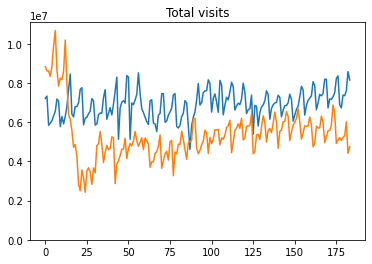

In [74]:
plt.plot(visit_2019_df.sum(axis=1))
plt.plot(visit_2020_df.sum(axis=1))
plt.title('Total visits')
plt.ylim(bottom = 0)

In [70]:
#len(place_types)
#place_types = [key for key in places_ext['place_type'].value_counts().keys()]
place_types

['other',
 'restaurant',
 'clinic',
 'recreation',
 'store',
 'worship',
 'pharmacy',
 'daycare',
 'supermarket',
 'convenience store',
 'long term care',
 'library',
 'bar',
 'museum',
 'hospital']

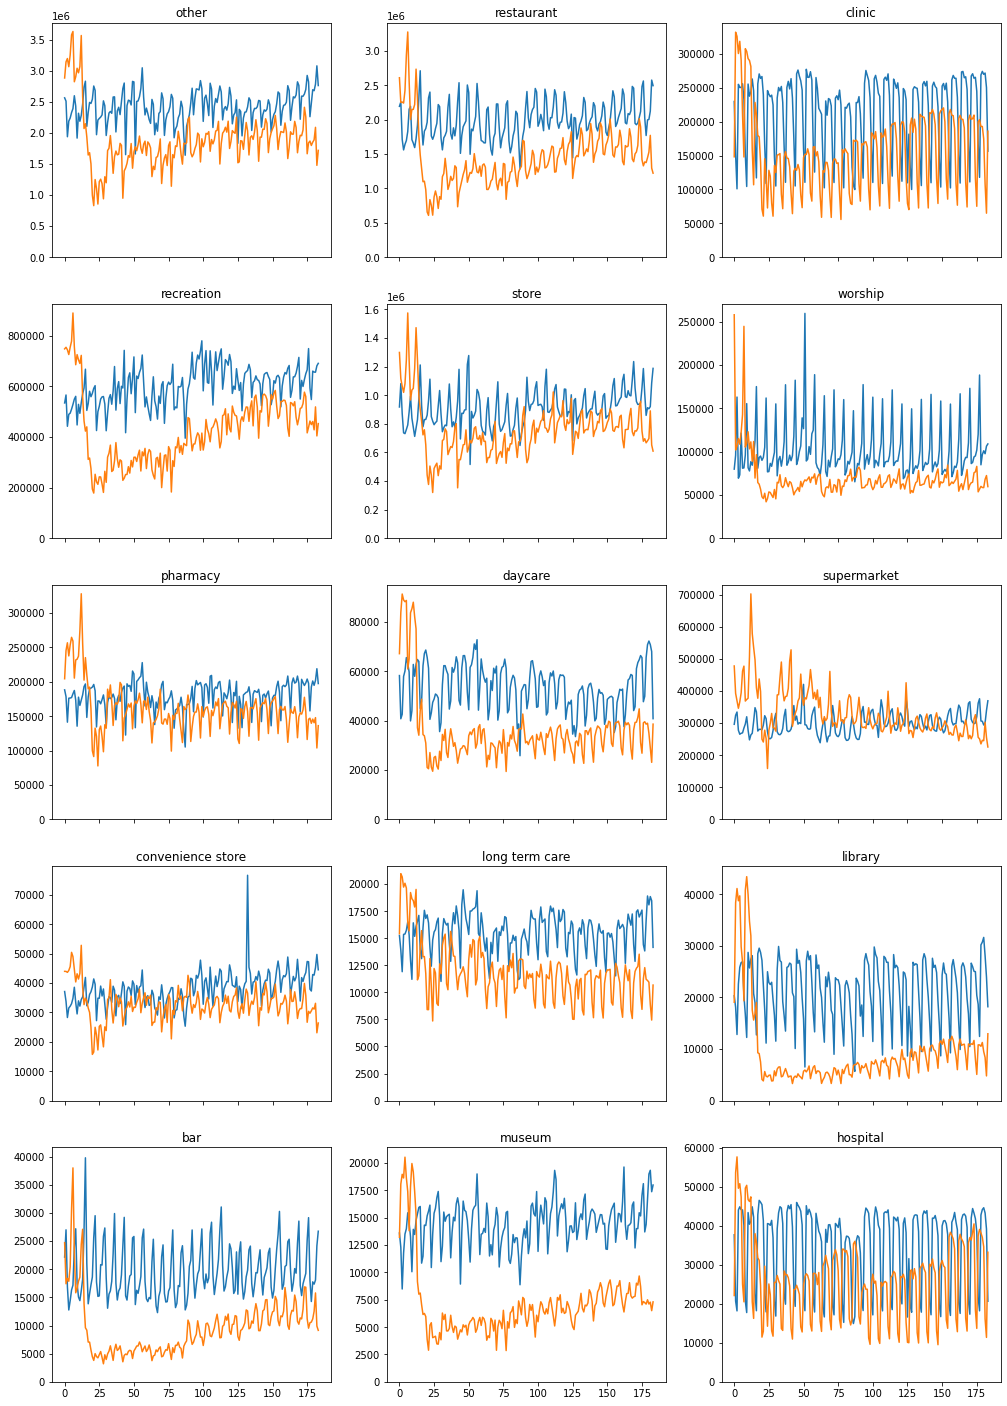

In [71]:
fig, axs = plt.subplots(5, 3, figsize=(17, 25), sharex='col')

for row in range(0,5):
  for col in range(0,3):
    idx = 3*row + col
    if idx < len(place_types):
      axs[row, col].plot(visit_2019_df[place_types[idx]], '-', label = '2019')
      axs[row, col].plot(visit_2020_df[place_types[idx]], '-', label = '2020')
      axs[row, col].set_title(place_types[idx])
      axs[row, col].set_ylim(bottom = 0)


#  ax[ii].legend()
#  ax[ii].xlabel('Days since March 1st')
#  ax[ii].ylabel('Total number of visits')
#  ax[ii].title(place_types[ii])


# Join `places_ext` with the original places to retrieve the NAICS code

In [76]:
large_places = pd.read_csv("drive/My Drive/SafeGraph/places/core_places_IL.csv")
large_places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132091 entries, 0 to 132090
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 132091 non-null  int64  
 1   safegraph_place_id         132091 non-null  object 
 2   parent_safegraph_place_id  18968 non-null   object 
 3   location_name              132091 non-null  object 
 4   safegraph_brand_ids        30605 non-null   object 
 5   brands                     30605 non-null   object 
 6   top_category               130284 non-null  object 
 7   sub_category               130284 non-null  object 
 8   naics_code                 130284 non-null  float64
 9   latitude                   132091 non-null  float64
 10  longitude                  132091 non-null  float64
 11  street_address             132091 non-null  object 
 12  city                       132091 non-null  object 
 13  region                     13

In [78]:
places_ext = places_ext.merge(large_places, on='safegraph_place_id')
places_ext['naics_2digit'] = places_ext['naics_code'].astype(str).apply(lambda x: x[0:2])
places_ext['naics_3digit'] = places_ext['naics_code'].astype(str).apply(lambda x: x[0:3])

In [98]:
places_visit_counts = patterns_2019[['safegraph_place_id', 'raw_visit_counts']].groupby('safegraph_place_id').sum()
places_ext = places_ext.merge(places_visit_counts, on='safegraph_place_id', how='left')

In [101]:
places_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95834 entries, 0 to 95833
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   safegraph_place_id         95834 non-null  object 
 1   place_type                 95834 non-null  object 
 2   Unnamed: 0                 95834 non-null  int64  
 3   parent_safegraph_place_id  10417 non-null  object 
 4   location_name              95834 non-null  object 
 5   safegraph_brand_ids        21899 non-null  object 
 6   brands                     21899 non-null  object 
 7   top_category               95551 non-null  object 
 8   sub_category               95551 non-null  object 
 9   naics_code                 95551 non-null  float64
 10  latitude                   95834 non-null  float64
 11  longitude                  95834 non-null  float64
 12  street_address             95834 non-null  object 
 13  city                       95834 non-null  obj

In [103]:
summ_2digits = places_ext[['place_type', 'naics_2digit', 'safegraph_place_id', 'raw_visit_counts']].groupby(['place_type', 'naics_2digit']).agg({'safegraph_place_id':'count', 'raw_visit_counts':'sum'})
summ_3digits = places_ext[['place_type', 'naics_3digit', 'safegraph_place_id', 'raw_visit_counts']].groupby(['place_type', 'naics_3digit']).agg({'safegraph_place_id':'count', 'raw_visit_counts':'sum'})

In [106]:
summ_2digits.to_csv("drive/My Drive/SafeGraph/summ_by_naics_2digits.csv")

In [107]:
summ_3digits.to_csv("drive/My Drive/SafeGraph/summ_by_naics_3digits.csv")